In [1]:
# importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import math
import numpy as np

#ML
from sktime.classification.feature_based import RandomIntervalClassifier

# metrics
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error

/home/apetrella/miniconda3/envs/battery_tsc/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# general parameters
len_series = 100  # the leght max of the time series

In [3]:
# Create Nasa Dataframe

#import dataset
list_cells= ['B0006','B0007','B0018']
nasa_dataset={}
for cell in list_cells:
    cell_dataset = scipy.io.loadmat('dataset/Nasa/5. Battery Data Set/DS/'+ cell +'.mat', simplify_cells=True)
    del cell_dataset["__header__"]
    del cell_dataset["__version__"]
    del cell_dataset["__globals__"]
    
    nasa_dataset[cell] = cell_dataset[cell]


# divide the dataset in 3 parts: charge, discharge and impedance
# in this work, we used only the charge part
 
nasa_dict={}

# for each cell
for cell in list_cells:
    nasa_dict[cell]={}
    nasa_dict[cell]['charge'] = []
    nasa_dict[cell]['discharge'] = []
    nasa_dict[cell]['impedance'] = []

    # save into the right part of dict
    for key in range(len(nasa_dataset[cell]['cycle'])):
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'charge' and key > 1 ):   # non cago il primo di ogni cella che vaneggia...
            nasa_dict[cell]['charge'].append(nasa_dataset[cell]['cycle'][key]['data'])

        if (nasa_dataset[cell]['cycle'][key]['type'] == 'discharge' ):
            nasa_dict[cell]['discharge'].append(nasa_dataset[cell]['cycle'][key]['data'])
        
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'impedance' ):
            nasa_dict[cell]['impedance'].append(nasa_dataset[cell]['cycle'][key]['data'])

    
    # to calculate the SoH, we need to know the capacity. we save the capacity information from discharge to charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        
        if (k < len(nasa_dict[cell]['discharge'])):
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['discharge'][k]['Capacity']
        else:
            # per ora ricopio l'ultimo letto
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['charge'][k-1]['SoH']


    #from capacity to SoH
    # the first one is 100, and the other ones are calculated
    start_Ah= 0
    for k,v in enumerate(nasa_dict[cell]['charge']):
        if (k == 0):
            start_Ah = nasa_dict[cell]['charge'][k]['SoH'] 
            nasa_dict[cell]['charge'][k]['SoH'] = 100
        else:
            nasa_dict[cell]['charge'][k]['SoH'] = int(round(nasa_dict[cell]['charge'][k]['SoH'] / start_Ah * 100))


    #convert array in panda series, it is nedded to use sktime.
    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict[cell]['charge'][k]['Voltage_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Voltage_measured'][:len_series])
        nasa_dict[cell]['charge'][k]['Temperature_measured'] = pd.Series(nasa_dict[cell]['charge'][k]['Temperature_measured'][:len_series])

        

# unify, the dataset, as a unique battery/cell
nasa_dict_unify={}
nasa_dict_unify['charge'] = []

for cell in list_cells:
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict_unify['charge'].append(v)


df_nasa= pd.DataFrame(nasa_dict_unify['charge'])

#rimuovo dati "non interessanti"(che non voglio usare)
df_nasa=df_nasa.drop("Current_charge",axis=1)
df_nasa=df_nasa.drop("Voltage_charge",axis=1)
df_nasa=df_nasa.drop("Time",axis=1)
df_nasa=df_nasa.drop("Current_measured",axis=1)

df_nasa

,Voltage_measured,Temperature_measured,SoH
0,0 3.209190 1 2.889684 2 3.320249 3...,0 31.874973 1 31.839292 2 31.86115...,100
1,0 3.219126 1 2.902853 2 3.327556 3...,0 32.137628 1 32.127910 2 32.14917...,99
2,0 3.267516 1 2.954284 2 3.376441 3...,0 32.010877 1 32.001274 2 32.01707...,99
3,0 3.299373 1 2.987839 2 3.407328 3...,0 31.920195 1 31.903038 2 31.92107...,99
4,0 3.283413 1 2.970440 2 3.391554 3...,0 32.032402 1 32.017581 2 32.03239...,98
...,...,...,...
466,0 3.487453 1 3.168863 2 3.546760 3...,0 33.872568 1 33.787686 2 33.78767...,73
467,0 3.494356 1 3.175670 2 3.556132 3...,0 34.158881 1 34.082038 2 34.07254...,73
468,0 3.515781 1 3.194762 2 3.578757 3...,0 33.942370 1 33.866384 2 33.85798...,73
469,0 3.685647 1 3.327417 2 3.775247 3...,0 25.102520 1 25.103878 2 25.19299...,72


In [5]:
# Create Nasa Dataframe for the test

#import dataset
list_cells= ['B0005']
nasa_dataset={}
for cell in list_cells:
    cell_dataset = scipy.io.loadmat('dataset/Nasa/5. Battery Data Set/DS/'+ cell +'.mat', simplify_cells=True)
    del cell_dataset["__header__"]
    del cell_dataset["__version__"]
    del cell_dataset["__globals__"]
    
    nasa_dataset[cell] = cell_dataset[cell]


# divide the dataset in 3 parts: charge, discharge and impedance
# in this work, we used only the charge part
 
nasa_dict_test={}

# for each cell
for cell in list_cells:
    nasa_dict_test[cell]={}
    nasa_dict_test[cell]['charge'] = []
    nasa_dict_test[cell]['discharge'] = []
    nasa_dict_test[cell]['impedance'] = []

    # save into the right part of dict
    for key in range(len(nasa_dataset[cell]['cycle'])):
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'charge' and key > 1 ):   # non cago il primo di ogni cella che vaneggia...
            nasa_dict_test[cell]['charge'].append(nasa_dataset[cell]['cycle'][key]['data'])

        if (nasa_dataset[cell]['cycle'][key]['type'] == 'discharge' ):
            nasa_dict_test[cell]['discharge'].append(nasa_dataset[cell]['cycle'][key]['data'])
        
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'impedance' ):
            nasa_dict_test[cell]['impedance'].append(nasa_dataset[cell]['cycle'][key]['data'])

    
    # to calculate the SoH, we need to know the capacity. we save the capacity information from discharge to charge
    for k,v in enumerate(nasa_dict_test[cell]['charge']):
        
        if (k < len(nasa_dict_test[cell]['discharge'])):
            nasa_dict_test[cell]['charge'][k]['SoH'] = nasa_dict_test[cell]['discharge'][k]['Capacity']
        else:
            # per ora ricopio l'ultimo letto
            nasa_dict_test[cell]['charge'][k]['SoH'] = nasa_dict_test[cell]['charge'][k-1]['SoH']


    #from capacity to SoH
    # the first one is 100, and the other ones are calculated
    start_Ah= 0
    for k,v in enumerate(nasa_dict_test[cell]['charge']):
        if (k == 0):
            start_Ah = nasa_dict_test[cell]['charge'][k]['SoH'] 
            nasa_dict_test[cell]['charge'][k]['SoH'] = 100
        else:
            nasa_dict_test[cell]['charge'][k]['SoH'] = int(round(nasa_dict_test[cell]['charge'][k]['SoH'] / start_Ah * 100))


    #convert array in panda series, it is nedded to use sktime.
    for k,v in enumerate(nasa_dict_test[cell]['charge']):
        nasa_dict_test[cell]['charge'][k]['Voltage_measured'] = pd.Series(nasa_dict_test[cell]['charge'][k]['Voltage_measured'][:len_series])
        nasa_dict_test[cell]['charge'][k]['Temperature_measured'] = pd.Series(nasa_dict_test[cell]['charge'][k]['Temperature_measured'][:len_series])

        

# unify, the dataset, as a unique battery/cell
nasa_dict_unify={}
nasa_dict_unify['charge'] = []

for cell in list_cells:
    # unisco charge
    for k,v in enumerate(nasa_dict_test[cell]['charge']):
        nasa_dict_unify['charge'].append(v)


df_nasa_test= pd.DataFrame(nasa_dict_unify['charge'])

#rimuovo dati "non interessanti"(che non voglio usare)
df_nasa_test=df_nasa_test.drop("Current_charge",axis=1)
df_nasa_test=df_nasa_test.drop("Voltage_charge",axis=1)
df_nasa_test=df_nasa_test.drop("Time",axis=1)
df_nasa_test=df_nasa_test.drop("Current_measured",axis=1)

df_nasa_test

,Voltage_measured,Temperature_measured,SoH
0,0 3.325055 1 3.001951 2 3.434644 3...,0 29.341851 1 29.335723 2 29.33471...,100
1,0 3.352604 1 3.035879 2 3.459468 3...,0 29.553301 1 29.538751 2 29.53900...,99
2,0 3.378799 1 3.066145 2 3.485569 3...,0 29.456340 1 29.436998 2 29.43251...,99
3,0 3.372871 1 3.063766 2 3.478147 3...,0 29.481334 1 29.461955 2 29.46636...,99
4,0 3.366775 1 3.059322 2 3.471082 3...,0 29.395820 1 29.389419 2 29.38870...,99
...,...,...,...
164,0 3.699242 1 3.336460 2 3.822466 3...,0 25.666845 1 25.670984 2 25.67443...,69
165,0 3.699663 1 3.336584 2 3.822209 3...,0 25.725618 1 25.724054 2 25.73173...,69
166,0 3.699801 1 3.335029 2 3.821946 3...,0 25.788535 1 25.776934 2 25.78475...,71
167,0 3.703203 1 3.337711 2 3.827229 3...,0 24.671571 1 24.675326 2 24.68509...,71


In [8]:
# remove if time series has a different lenght
# there is time series more shorter than len_series 
for index, row in df_nasa.iterrows():
    if(len(row['Temperature_measured']) != len_series ):  
        df_nasa = df_nasa.drop(index)
        print('drop')
for index, row in df_nasa_test.iterrows():
    if(len(row['Temperature_measured']) != len_series ):  
        df_nasa_test = df_nasa_test.drop(index)
        print('drop')

drop
drop
drop


In [9]:
# divide dataset in train set and test set


x_train = df_nasa
y_train = x_train['SoH'].copy().astype('int')
x_train = x_train.drop(columns=['SoH'])

x_test = df_nasa_test
y_test = x_test['SoH'].copy().astype('int') 
x_test = x_test.drop(columns=['SoH'])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(469, 2) (469,)
(168, 2) (168,)


In [10]:
# random interval

clf = RandomIntervalClassifier(n_intervals=5,random_state=1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

MAE% = 0.011262689131314434
MAE = 0.9347826086956522
RMSE = 1.5948285992135849


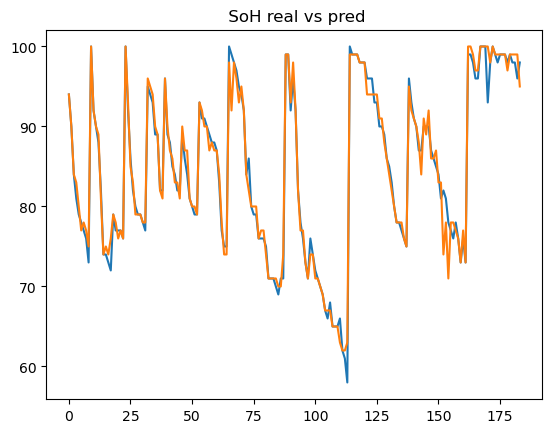

In [ ]:
# plot and metrics

print('MAE% = ' + str(mean_absolute_percentage_error(y_test, y_pred)))
print('MAE = ' + str(mean_absolute_error(y_test, y_pred)))
print('RMSE = ' + str(np.sqrt(np.square(np.subtract(y_test,y_pred)).mean())))


plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

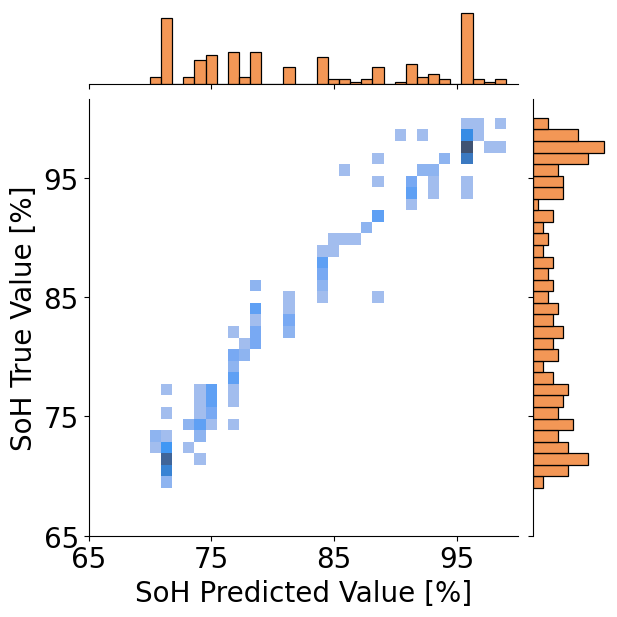

In [11]:
# plotting

import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


real_pred = {
    'real':y_test.values,
    'pred':y_pred
}
df_plot = pd.DataFrame(real_pred)

colors = ["#F0741E", "#276CB3"]

class_names = np.union1d(np.unique(df_plot['real']), (np.unique(df_plot['pred'])))


g = sns.jointplot(x="pred", 
                  y="real", 
                  data=df_plot, 
                  kind="hist", 
                  marginal_kws={"color": colors[0], "bins":len(class_names)},
                  joint_kws={"color": colors[1], "bins": len(class_names)} 
                  )


g.ax_joint.tick_params(axis="both", which="major", labelsize=20)
ticks = np.arange(65, 101, 10)
labels = [f'{x}' for x in ticks]
g.ax_joint.set_xlim([min(class_names),max(class_names)])
g.ax_joint.set_yticks(ticks,labels=labels)
g.ax_joint.set_xticks(ticks,labels=labels)

g.set_axis_labels(
    'SoH Predicted Value [%]', 'SoH True Value [%]' ,fontsize=20
)

plt.savefig('plot/100_nasa_oxford.png', dpi=300, bbox_inches="tight")